In [1]:
import numpy as np
import pandas as pd  # Importare pandas per il caricamento del CSV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split  # Importa per il train/val split
from tensorflow.keras import regularizers

# Step 1: Caricare il dataframe da train.csv
df = pd.read_csv('train.csv')  # Carica il dataframe

# Assicurati che la colonna "default payment next month" contenga solo valori binari
df['default payment next month'] = df['default payment next month'].apply(lambda x: 1 if x > 0 else (0 if x == 0 else np.nan))

# Rimuovi righe con valori NaN
df.dropna(subset=['default payment next month'], inplace=True)

# Step 1.1: Definire X_train e y_train
X = df.drop(columns=['default payment next month']).values  # Tutte le colonne tranne "default payment next month"
y = df['default payment next month'].values  # Utilizza i valori della colonna "default payment next month"

# Step 1.2: Suddividere il dataset in training e validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizzare i dati di input
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Normalizza X_train
X_val_scaled = scaler.transform(X_val)  # Normalizza X_val con lo stesso scaler

# Step 2: Definire l'architettura della rete neurale con meno regularizzazione e più complessità
def build_model(input_shape):
    model = Sequential()
    model.add(Input(shape=(input_shape,)))

    # Primo livello con He initialization, regularizzazione L2 ridotta e Batch Normalization
    model.add(Dense(256, activation='relu', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(BatchNormalization())

    # Secondo livello con più neuroni
    model.add(Dense(128, activation='relu', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(BatchNormalization())

    # Terzo livello con più neuroni
    model.add(Dense(64, activation='relu', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(BatchNormalization())

    # Quarto livello aggiunto per aumentare la complessità
    model.add(Dense(32, activation='relu', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(BatchNormalization())

    # Livello di output con attivazione sigmoid
    model.add(Dense(1, activation='sigmoid'))

    # Compilare il modello con un learning rate leggermente più alto
    optimizer = Adam(learning_rate=0.0003, clipnorm=1.0)  # Clipnorm per evitare gradienti esplosivi
    model.compile(optimizer=optimizer, 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])

    return model

# Step 3: Costruire il modello
input_shape = X_train_scaled.shape[1]  
model = build_model(input_shape)

# Step 4: Definire i parametri di addestramento
batch_size = 64
epochs = 50

# Step 5: Early stopping e learning rate scheduler per prevenire l'overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)

model.summary()

# Step 6: Addestrare il modello
history = model.fit(X_train_scaled, y_train, 
                    validation_data=(X_val_scaled, y_val),
                    epochs=epochs, batch_size=batch_size, 
                    callbacks=[early_stopping, reduce_lr])

# Step 7: Valutare il modello sul set di validazione
val_loss, val_accuracy = model.evaluate(X_val_scaled, y_val)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

# Step 8: Calcolare e stampare l'F1 Score
y_pred_prob = model.predict(X_val_scaled)  
y_pred = (y_pred_prob > 0.5).astype(int)  

# Modifica il calcolo dell'F1 score
f1 = f1_score(y_val, y_pred, average='macro')  
print(f"F1 Score: {f1}")

2024-10-24 11:04:46.419312: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │         6,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,585 (201.50 KB)

 Trainable params: 50,625 (197.75 KB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/50


KeyboardInterrupt: 

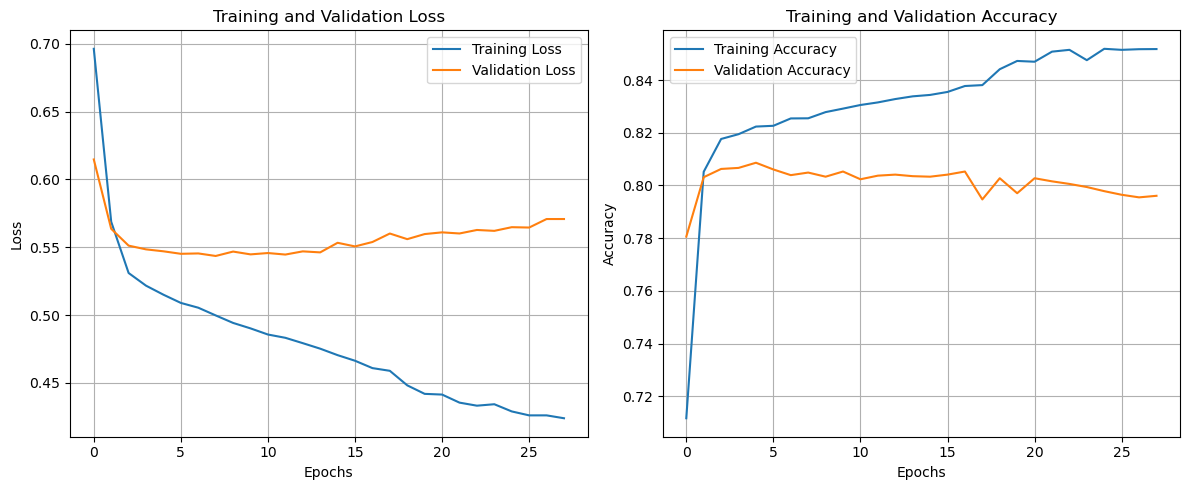

Final Training Loss: 0.4240
Final Validation Loss: 0.5708
Final Training Accuracy: 0.8518
Final Validation Accuracy: 0.7961
The model performs better on the training set compared to the validation set, which might indicate overfitting.


In [2]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """
    Plot the training and validation loss and accuracy over epochs.

    Parameters
    ----------
    history: History
        Keras History object containing training metrics.
    """
    # Plotting Loss
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    # Plotting Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

# Step 1: Call the plot function to visualize the training history
plot_training_history(history)

# Step 2: Analyze results
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]
final_train_accuracy = history.history['accuracy'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]

print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")
print(f"Final Training Accuracy: {final_train_accuracy:.4f}")
print(f"Final Validation Accuracy: {final_val_accuracy:.4f}")

# Step 3: Initial considerations
if final_train_loss < final_val_loss:
    print("The model performs better on the training set compared to the validation set, which might indicate overfitting.")
elif final_train_loss > final_val_loss:
    print("The model performs better on the validation set compared to the training set, indicating potential underfitting.")
else:
    print("The model performs similarly on both sets, suggesting a good fit.")